# Identify Object Positions in Images - YOLO vs VLM 

In [ ]:
# Importiere YOLO und lade ein vortrainiertes Modell
from ultralytics import YOLO

# Lade das vortrainierte YOLOv8 Modell (nano Version)
model = YOLO('yolov8n.pt')  # Kleines Modell für schnelle Inferenz

# Definiere das zu suchende Objekt
target_object_name = "cup"  # Ersetze mit dem gewünschten Objektnamen (z.B. "person", "car", "bottle")

# Hole alle Klassennamen, die das Modell kennt (z.B. person, car, cup, etc.)
class_names = model.names

# Finde die Klassen-ID für das Zielobjekt
# Durchsucht alle Klassen und gibt die ID zurück, wenn der Name übereinstimmt
target_class_id = next((class_id for class_id, name in class_names.items() if name == target_object_name), None)

# Prüfe, ob das Objekt in den Modellklassen gefunden wurde
if target_class_id is not None:
    # Führe die Objekterkennung auf dem Bild durch
    results = model('images/table_scene.jpeg', save=True)  # Ersetze mit deinem Bildpfad
    
    # Extrahiere alle erkannten Bounding Boxes aus den Ergebnissen
    detections = results[0].boxes
    
    # Filtere nur die Bounding Boxes, die zum Zielobjekt gehören
    # List Comprehension: Durchläuft alle Boxen und behält nur die mit der richtigen Klassen-ID
    specific_boxes = [
        box.xyxy[0].tolist()  # xyxy Format: [x_min, y_min, x_max, y_max]
        for box in detections
        if int(box.cls[0]) == target_class_id  # Filtere nach Klassen-ID
    ]
    
    # Gib die gefundenen Bounding Boxes für das Zielobjekt aus
    print(f"Bounding boxes for '{target_object_name}': {specific_boxes}")
else:
    # Falls das Objekt nicht in den Modellklassen vorhanden ist
    print(f"Object name '{target_object_name}' not found in the model's class names.")

image 1/1 /workspaces/B3-AP3-MultimodalInteraction_ObjDet/images/table_scene.jpeg: 640x640 1 cup, 2 potted plants, 2 dining tables, 4 books, 3 vases, 234.7ms
Speed: 10.3ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict13
Bounding boxes for 'cup': [[615.28662109375, 553.363525390625, 845.9586181640625, 780.4920654296875]]


### Utils 


In [13]:

import json
import re
from PIL import Image, ImageDraw
from PIL import ImageColor

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

#this function is needed to plot bounding boxes on images 
def plot_bounding_boxes(im, positions):
    """
    Plots bounding boxes on an image with markers for each noun phrase, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        noun_phrases_and_positions: A list of tuples containing the noun phrases
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    print(img.size)
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = [
    'red',
    'green',
    'blue',
    'yellow',
    'orange',
    ] + additional_colors

    # Iterate over the noun phrases and their positions
    for i, ((y1, x1, y2, x2)) in enumerate(positions):
        # Select a color from the list
        color = colors[i % len(colors)]

        # Convert normalized coordinates to absolute coordinates
        abs_x1 = int(x1/1000 * width)
        abs_y1 = int(y1/1000 * height)
        abs_x2 = int(x2/1000 * width)
        abs_y2 = int(y2/1000 * height)

        # Draw the bounding box
        draw.rectangle(
            ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4
        )

        # Draw the text
        #draw.text((abs_x1 + 8, abs_y1 + 6), noun_phrase, fill=color)

    # Display the image
    img.show()

# if the boxes coordinates are output not as json but as text, should be parsed first
def parse_list_boxes(text):
  result = []
  for line in text.strip().splitlines():
    # Extract the numbers from the line, remove brackets and split by comma
    try:
      numbers = line.split('[')[1].split(']')[0].split(',')
    except:
      numbers =  line.split('- ')[1].split(',')

    # Convert the numbers to integers and append to the result
    result.append([int(num.strip()) for num in numbers])

  return result



# VLM (1): OPEN-AI

In [15]:
import openai
from dotenv import load_dotenv  
import base64

# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

load_dotenv()
openAIclient = openai.OpenAI()

img = "images/table_scene.jpeg"


In [16]:
#basic call to gpt4 with prompt and image

import json

completion = openAIclient.chat.completions.create(
    model="gpt-4.1-mini",
    messages=[
        {
            "role": "user",
            "content": [
                {"type": "text", "text": "Detect if there is a brown cup with an handle (and an shadow) in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax], normalize the coordinate to 0-1000. Just output the list in json."},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encode_image(img)}",
                    }
                },
            ],
        }
    ],
    response_format={"type": "json_object"},
)

# Wrap the text to a specified width
response = str(completion.choices[0].message.content)



Load answer in a python dict and/or parse the json before if needed

In [17]:
detection = json.loads(response)
detection

{'ymin': 630, 'xmin': 580, 'ymax': 810, 'xmax': 770}

now parse and plot bounding boxes. Consider the format the utils function want the bounding boxes to be plotted!

In [18]:
#boxes= parse_list_boxes(str(detection['coordinates'])) #depending whether you managed to output a json or not. If your output is still in "str" form you might need to parse it with this util function
boxes= [detection['coordinates']]
print(boxes)
plot_bounding_boxes(Image.open(img), positions=list(boxes))

KeyError: 'coordinates'

# VLM (2): GEMINI


In [32]:
%matplotlib inline
from dotenv import load_dotenv  
from google import genai
from PIL import Image

load_dotenv()
client = genai.Client()


In [33]:
im = Image.open(img)

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=[
        im,
        (
            "Detect if there is a cup in the image and reutrn its coordinates as a list in the format [ymin,xmin, ymax, xmax], normalize the coordinate to 0-1000. answer should be json format only"
        ),
        
    ],
    config={"response_mime_type": "application/json"}
)

print(response.text)


{"cup": [540, 602, 762, 826]}


Ah! Output is a list! because I asked for it in the prompt - either you leave it and take account in parsing, or you remove the word "list" in prompt.

In [34]:
json.loads(response.text)

{'cup': [540, 602, 762, 826]}

(1024, 1024)


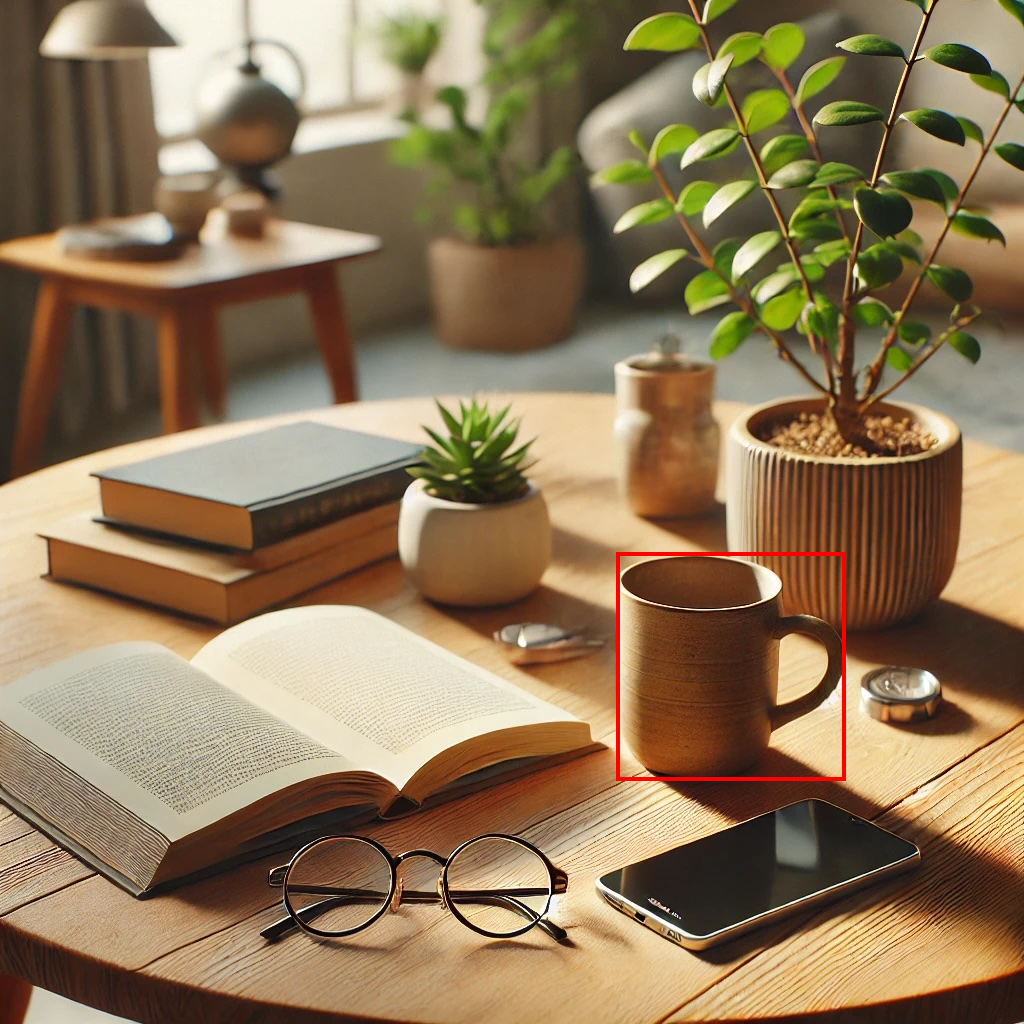

In [35]:
#boxes= parse_list_boxes(response.text) # same comment as above
box_coord = [json.loads(response.text)['cup']] #access the coordinates using the 'cup' key
plot_bounding_boxes(im,positions=list(box_coord))